In [1]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [495]:
import geehydro
import folium
import pandas as pd
import matplotlib.pyplot as plt

In [496]:
# declare geography / the area of interest
country = "Germany"

countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
roi = countries.filter(ee.Filter.eq("country_na", country))
#print(f"type of roi is {type(roi)}")

# Initiating radiance map with country boundary
Radiance_Map = folium.Map(zoom_start=10)
Radiance_Map.addLayer(ee.Image().paint(roi, 0, 2))

Radiance_Map.centerObject(roi, 6)
#Radiance_Map

# prepare dataset from satellite for dates of interest
dataset = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').filter(ee.Filter.date('2021-12-30', '2022-01-02'))
#print(f"type of dataset is {type(dataset)}")

#prepare sample_image data for latitude-longitude of pixels for country of interest
latlng_sample_image = dataset.first().clip(roi)

#prepare average_radiance data from mean values of pixel data for country of interest
radiance_image = dataset.select('avg_rad').mean().clip(roi)

In [497]:
# Extract radiance data for the image as a list of lists
radiance_image_data = radiance_image.reduceRegion(
    reducer=ee.Reducer.toList(), 
    geometry=roi, 
    scale=1000
).getInfo()


# get count of pixels under roi
print(len(radiance_image_data['avg_rad']))

radiance_values_table = pd.DataFrame(radiance_image_data)
print(radiance_values_table.head(5))

568704
   avg_rad
0   0.6225
1   0.6450
2   0.6400
3   0.6000
4   0.6725


In [498]:
# Extract the longitude and latitude values for each pixel
latlng = latlng_sample_image.pixelLonLat().reduceRegion(
    reducer=ee.Reducer.toList(), 
    geometry=roi, 
    scale=1000
).getInfo()

# verify count of lat-long combination values to match with the pixel values
len(latlng['latitude'])
# len(latlng['longitude'])

568704

In [499]:
# calculate difference in count of entries in both dataframes
print(f"{len(latlng['latitude']) - len(radiance_image_data['avg_rad'])}")

0


In [500]:
df_latlng = pd.DataFrame(latlng)
#df_latlng.head(20)

param_values_mapped = df_latlng
param_values_mapped['avg_rad'] = radiance_image_data['avg_rad']

param_values_mapped

,latitude,longitude,avg_rad
0,47.273842,10.173421,0.6225
1,47.273842,10.182404,0.6450
2,47.273842,10.191387,0.6400
3,47.273842,10.227320,0.6000
4,47.273842,10.236303,0.6725
...,...,...,...
568699,55.044269,8.457638,0.2225
568700,55.053252,8.403739,0.3150
568701,55.053252,8.412723,0.3125
568702,55.053252,8.421706,0.2975


(-0.17000000178813934, 746.8599853515625)
1.4243848457709214


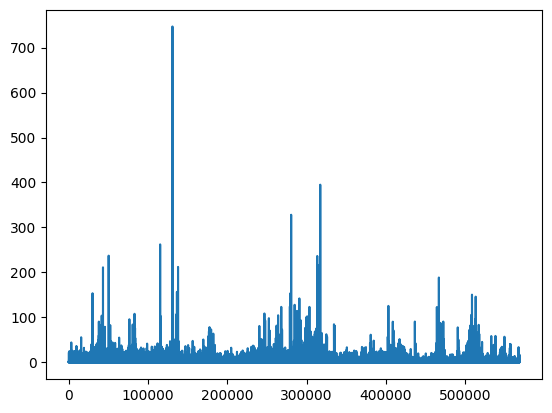

In [501]:
print(f"({param_values_mapped['avg_rad'].min()}, {param_values_mapped['avg_rad'].max()})")
print(param_values_mapped['avg_rad'].mean())
param_values_mapped['avg_rad'].plot()
plt.show()

In [502]:
#checking upper bound of 99% of the values
param_values_mapped[param_values_mapped['avg_rad']<=20].count() / param_values_mapped['avg_rad'].count()

latitude     0.994975
longitude    0.994975
avg_rad      0.994975
dtype: float64

In [503]:
nighttimeVis = {
  'min': param_values_mapped['avg_rad'].min(),
  'max': 20.0,
  'palette': ['black', 'yellow', 'red']
}

# adding radiance layer on the map with only country of interest

Radiance_Map.addLayer(radiance_image, nighttimeVis, 'Nighttime')
Radiance_Map.setControlVisibility(layerControl=True, fullscreenControl=True)
Radiance_Map.centerObject(roi, 4)
Radiance_Map